# Implement a Trading Bot using Reinforcement Learning

when you check on the history in the git repo I wanted to try reiforcement learning on trading for a while. But since I have a kind of working model I did not give it a very high priority. However recently I just stumbled over this Article [Creating Bitcoin trading bots don't lose money](https://towardsdatascience.com/creating-bitcoin-trading-bots-that-dont-lose-money-2e7165fb0b29). And since I have time now, I have quickly implemented the Reinforcement Model and tried to kind of reproduce this Article.

However, since I have this GAF encoding fuction lying around but I never had the mood to properly design a CNN (which is rather tedious), I will try something slightly different and use GAF encoded features as inputs. As can be found at [Encoding Candlesticks as Images for Patterns Classification](https://arxiv.org/abs/1901.05237)

Lets start with our imports and fetch some data:

```
!pip install pandas-ml-common pandas-ml-utils pandas-ml-quant
```

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt

from pandas_ml_utils.ml.data.splitting import RandomSequences
from pandas_ml_utils import FeaturesAndLabels, Model, ReinforcementModel
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels
from pandas_ml_common import Constant

automatically imported pandas_ml_utils 0.1.2


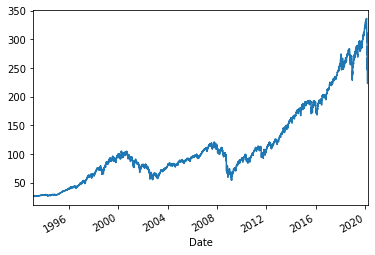

In [2]:
df = pd.fetch_yahoo('SPY')
df["Close"].plot()

In the next step I want to show you how a GAF encoded feature space will look like. 

1. First we convert our candle sticks to *c*lose, *u*pper-shaddow, *l*ower-shaddow and *body*.
2. Then we lag out features for 280 trading days -> this will give us a 3D tensor later (?, 280, 5) which reads (batch size, time steps, features)
3. Finally we use the 280 trading day window and GAF encode it for every time step

Note that the features and labels object is designed for traditional statistical model where you try to fit a label. In this case we do not have a label as the algorithm learnd from the reward function. But we still need to provide it so I just pass a constant value. Hoever I think I am going to missuse the field later to pass a benchmark. Also note for this model it is important to pass a target as this is used in the reward function!

In [3]:
features_and_labels = PostProcessedFeaturesAndLabels(
    features=[                
        lambda df: df.ta.candles_as_culb()
    ],
    feature_post_processor=[
        lambda df: df.ta.rnn(280),
        lambda df: df.ta.gaf(image_size=52, sample_range=(0, 1),)
    ],
    labels=[
        Constant(0)
    ],
    targets=[
        lambda df: df["Close"]
    ],
)

(features, min_needed_samples), labels, target, sample_weights = df._.extract(features_and_labels)
features[-100:].ta.plot(1,1).plot_matrix_animation("close_gaf")

Now it is time to define our environment, there are two things to mention:

1. the CNN policies expect a channel last image so we need to swap axis
1. and a domain of [0, 255] so we need to upscale from our [0, 1] scaled data


In [4]:
from pandas_ml_quant.model.rl_trading_agent import TradingAgentGym

class TradeSpyGAFGym(TradingAgentGym):

    def calculate_trade_reward(self, portfolio_performance_log):
        return portfolio_performance_log["net"].iloc[-1]

    def next_observation(self, idx, features, labels, targets, weights):
        return features.swapaxes(0, 1).swapaxes(1, 2) * 255


Time to let our agent learn something. But we don't allow the bot to short sell and we stop the current session if the bot lost more then 20% since he started trading.

  _np_qint8 = np.dtype([("qint8", np.int8, 1)])

  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])

  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

  _np_quint16 = np.dtype([("quint16", np.uint16, 1)])

  _np_qint32 = np.dtype([("qint32", np.int32, 1)])

  np_resource = np.dtype([("resource", np.ubyte, 1)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


worst reward: -6.800687576660096


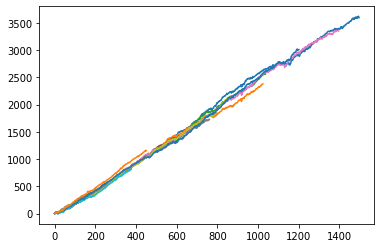

In [5]:
from stable_baselines import PPO2
from stable_baselines.common.vec_env import DummyVecEnv

fit = df.model.fit(
    ReinforcementModel(
        lambda: PPO2('CnnLstmPolicy',
                     DummyVecEnv([lambda: TradeSpyGAFGym((52, 52, 5), 
                                                         trading_fraction=10,
                                                         initial_capital=100, 
                                                         allow_short=False,
                                                         stop_if_lost=None,
                                                         commission=lambda _: 2.0)]),
                     nminibatches=1),
        features_and_labels,
    ),
    RandomSequences(0.1, 0.7, max_folds=None),
    total_timesteps=10000,
    verbose=1,
    render='system'
)

fit.model.plot_loss()

Now let's check on the reward our agents have made: